In [1]:
# 清除内存，预防报错
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import tensorflow as tf
import gc
 
# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()
 
    try:
        del classifier # this is from global space - change this as you need
    except:
        pass
 
    print(gc.collect()) # if it does something you should see a number as output
 
    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))


In [2]:
reset_keras()

22


In [3]:
train_root = r'D:\Program Files (x86)\pythonProject\python文件\南洋理工\new622\train'
test_root = r'D:\Program Files (x86)\pythonProject\python文件\南洋理工\new622\test'
val_root = r'D:\Program Files (x86)\pythonProject\python文件\南洋理工\new622\val'

In [4]:
# 参数初始化
dim = (224,224)                            

In [5]:
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard
import pickle
from PIL import Image
import time
import os
from PIL import Image
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from keras import regularizers

In [25]:
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
import math

earlyStopping = EarlyStopping(
    monitor='val_accuracy', patience=8, verbose=1, mode='max', restore_best_weights=True)

reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                           patience=5, verbose=1, mode='max', cooldown=1, min_lr=1e-8)

callback_list = [earlyStopping, reduce]

#设置回调函数用于后续训练

In [24]:
#设置优化器
# opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=True,name='SGD') 
adam=tf.keras.optimizers.Adam(learning_rate=0.001)

In [8]:
def get_result_2(model_history,vg_model,test_data):
    #     train_scores = vg_model.evaluate(train_data, train_labels)
#     val_scores = vg_model.evaluate(val_data,val_labels)
    test_scores = vg_model.evaluate(test_data)

#     print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
#     print('Validation Accuracy: %.2f%%'%(val_scores[1]*100))
    print('Test Accuracy: %.2f%%'%(test_scores[1]*100))
    
    fig, ax = plt.subplots(1, 3, figsize = (30, 5))
    ax = ax.ravel()

    for i, metric in enumerate(["accuracy", "loss"]):
        ax[i].plot(model_history.history[metric])
        ax[i].plot(model_history.history["val_" + metric])
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("Epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["train", "val"])
        
    pred = vg_model.predict(test_data)
    pred=np.argmax(pred,axis=1)
    
    # TTA_WAY

    cm = confusion_matrix(y_true= test_data.classes,y_pred=pred,labels=[0,1,2,3])

    # sns.heatmap(cm,annot = True)
    plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    ax = sn.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels= ['Mild', 'Moderate', 'Normal', 'VeryMild'],
            yticklabels=['Mild', 'Moderate', 'Normal', 'VeryMild'])
    plt.title('Alzheimer\'s Diagnosis')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    # plt.subplots(figsize=(9, 6))
    plt.show(ax)
    print('------Weighted------')
    print('Weighted precision', precision_score(test_data.classes, pred, average='weighted'))
    print('Weighted recall', recall_score(test_data.classes, pred, average='weighted'))
    print('Weighted f1-score', f1_score(test_data.classes, pred, average='weighted'))
    print('------Macro------')
    print('Macro precision', precision_score(test_data.classes, pred, average='macro'))
    print('Macro recall', recall_score(test_data.classes, pred, average='macro'))
    print('Macro f1-score', f1_score(test_data.classes, pred, average='macro'))
    print('------Micro------')
    print('Micro precision', precision_score(test_data.classes, pred, average='micro'))
    print('Micro recall', recall_score(test_data.classes, pred, average='micro'))
    print('Micro f1-score', f1_score(test_data.classes, pred, average='micro'))
    
#     tta_steps = 10

#     predictions = []
    
#     for i in range(tta_steps):
#     #     preds = model.predict_generator(test_datagen.flow(test_data, batch_size=batch_size, shuffle=False), steps = len(test_data)/batch_size)
#         preds = model.predict(test_data_TTA,verbose=0)
#         predictions.append(preds)

#     final_pred = np.mean(predictions, axis=0)
#     pred = np.argmax(final_pred, axis=-1)
#     true = test_data.classes
    
#     print('------TTA_SCORE------')
#     print(f'Accuracy with TTA: {np.mean(np.equal(pred,true))}')
    


In [14]:

DenseNet_model = tf.keras.applications.DenseNet121(weights=None,
    classes=4) 

DenseNet_model.summary()

# model=Sequential()
# model.add(DenseNet_model)
# model.add(Dense(4,activation='softmax') )
# model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                       

 conv2_block4_0_relu (Activatio  (None, 56, 56, 160)  0          ['conv2_block4_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)       

 ization)                                                                                         
                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_blo

 conv3_block10_concat (Concaten  (None, 28, 28, 448)  0          ['conv3_block9_concat[0][0]',    
 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
          

                                                                                                  
 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block7_0_relu (Activatio  (None, 14, 14, 448)  0          ['conv4_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)

 ate)                                                             'conv4_block15_2_conv[0][0]']   
                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_rel

 ization)                                                                                         
                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_blo

 conv5_block8_concat (Concatena  (None, 7, 7, 768)   0           ['conv5_block7_concat[0][0]',    
 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
          

 on)                                                                                              
                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

__________________________________________________________________________________________________


In [15]:
DenseNet_model.compile(optimizer=adam, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [12]:
#生成数据
zoom = [.99,1.01]             
bright_range = [.8,1.2]                               
momentum = .9   

Generator = ImageDataGenerator( rescale=1./255,
                                    fill_mode='constant',
                                    cval=0,
                                    brightness_range=bright_range,
                                    zoom_range=zoom,
                                    data_format='channels_last',
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    validation_split = 0.2,
                                    zca_whitening=False)

    # train_data_gen = train_dr.flow_from_directory(directory=train_root,target_size=,
    #                                               batch_size=5000)

batch_size =15

train_data  = Generator.flow_from_directory(directory = train_root,
                                            target_size = dim,
                                            class_mode = 'categorical',#独热标签

                                            batch_size = batch_size)


valid_data = Generator.flow_from_directory(directory = val_root,
                                                  target_size = dim,
                                                  class_mode = 'categorical',

                                                  batch_size = batch_size)


# Change to zoom = [1,1] to use normal test data
test_Generator = ImageDataGenerator(rescale=1./255,
                                    fill_mode='constant',
                                    cval=0,
                                    zoom_range=[1,1],
                                    data_format='channels_last') 

test_data = test_Generator.flow_from_directory(directory=test_root,
                                        target_size=dim,
                                        batch_size = batch_size,
                                        shuffle = False) # test data should not be shuffled to keep labels

Found 6852 images belonging to 4 classes.
Found 2283 images belonging to 4 classes.
Found 2289 images belonging to 4 classes.


In [16]:
#训练模型
model_history = DenseNet_model.fit(train_data,validation_data=valid_data,
                          batch_size = 20,
                          callbacks= callback_list,
                          epochs=100, shuffle=True) 


Epoch 1/100
457/457 [==============================] - 164s 324ms/step - loss: 1.0475 - accuracy: 0.4942 - val_loss: 1.1655 - val_accuracy: 0.4529 - lr: 0.0010
Epoch 2/100
457/457 [==============================] - 149s 326ms/step - loss: 0.9480 - accuracy: 0.5385 - val_loss: 1.2322 - val_accuracy: 0.3198 - lr: 0.0010
Epoch 3/100
457/457 [==============================] - 152s 332ms/step - loss: 0.9236 - accuracy: 0.5463 - val_loss: 1.1514 - val_accuracy: 0.5462 - lr: 0.0010
Epoch 4/100
457/457 [==============================] - 151s 330ms/step - loss: 0.9089 - accuracy: 0.5431 - val_loss: 0.9799 - val_accuracy: 0.5221 - lr: 0.0010
Epoch 5/100
457/457 [==============================] - 151s 331ms/step - loss: 0.8897 - accuracy: 0.5541 - val_loss: 2.1742 - val_accuracy: 0.4420 - lr: 0.0010
Epoch 6/100
457/457 [==============================] - 151s 330ms/step - loss: 0.8844 - accuracy: 0.5645 - val_loss: 1.4480 - val_accuracy: 0.5090 - lr: 0.0010
Epoch 7/100
457/457 [===================

457/457 [==============================] - ETA: 0s - loss: 0.4773 - accuracy: 0.8081
Epoch 49: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
457/457 [==============================] - 150s 327ms/step - loss: 0.4773 - accuracy: 0.8081 - val_loss: 0.5208 - val_accuracy: 0.7884 - lr: 1.0000e-05
Epoch 50/100
457/457 [==============================] - 150s 327ms/step - loss: 0.4694 - accuracy: 0.8145 - val_loss: 0.5069 - val_accuracy: 0.7946 - lr: 1.0000e-06
Epoch 51/100
457/457 [==============================] - 150s 328ms/step - loss: 0.4797 - accuracy: 0.8049 - val_loss: 0.5065 - val_accuracy: 0.7950 - lr: 1.0000e-06
Epoch 52/100
457/457 [==============================] - 150s 328ms/step - loss: 0.4795 - accuracy: 0.8043 - val_loss: 0.5017 - val_accuracy: 0.7963 - lr: 1.0000e-06
Epoch 53/100
457/457 [==============================] - 150s 327ms/step - loss: 0.4739 - accuracy: 0.8098 - val_loss: 0.5035 - val_accuracy: 0.7893 - lr: 1.0000e-06
Epoch 54/100
457/457 [===

153/153 [==============================] - 10s 59ms/step - loss: 0.5027 - accuracy: 0.8082
Test Accuracy: 80.82%
153/153 [==============================] - 11s 56ms/step


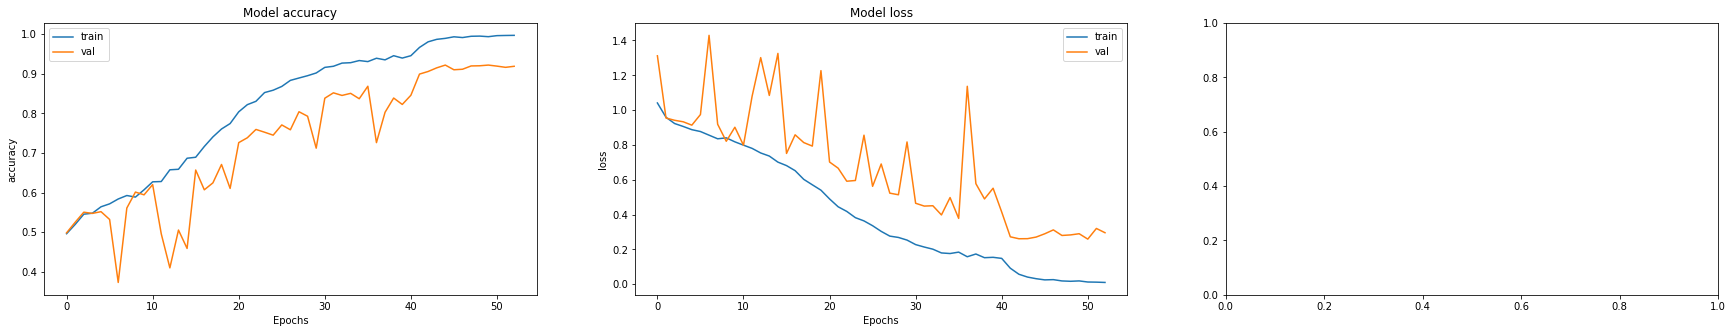

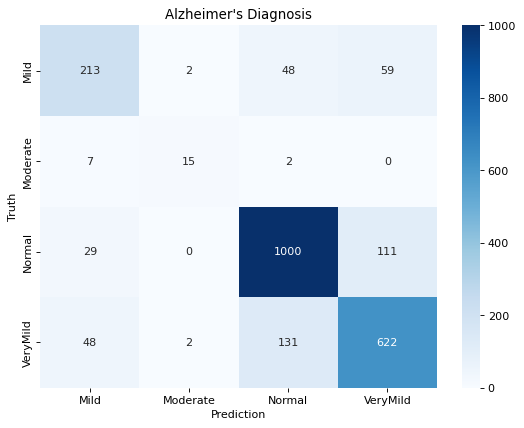

------Weighted------
Weighted precision 0.8063779852146151
Weighted recall 0.8082131935342944
Weighted f1-score 0.8068901819038099
------Macro------
Macro precision 0.7846847468850455
Macro recall 0.7345697333579767
Macro f1-score 0.756879012994801
------Micro------
Micro precision 0.8082131935342944
Micro recall 0.8082131935342944
Micro f1-score 0.8082131935342944


In [31]:
get_result_2(model_history,DenseNet_model,test_data)

In [18]:
reset_keras()

15156


In [27]:
Mob_model = tf.keras.applications.MobileNet(weights=None,classes=4) 

Mob_model.summary()





Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [28]:
Mob_model.compile(optimizer=adam, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [29]:
#训练模型
model_history = Mob_model.fit(train_data,validation_data=valid_data,
                          batch_size = 20,
                          callbacks= callback_list,
                          epochs=100, shuffle=True) 


Epoch 1/100
457/457 [==============================] - 118s 252ms/step - loss: 1.0412 - accuracy: 0.4962 - val_loss: 1.3121 - val_accuracy: 0.4985 - lr: 0.0010
Epoch 2/100
457/457 [==============================] - 120s 263ms/step - loss: 0.9589 - accuracy: 0.5197 - val_loss: 0.9548 - val_accuracy: 0.5252 - lr: 0.0010
Epoch 3/100
457/457 [==============================] - 121s 264ms/step - loss: 0.9231 - accuracy: 0.5455 - val_loss: 0.9418 - val_accuracy: 0.5506 - lr: 0.0010
Epoch 4/100
457/457 [==============================] - 122s 267ms/step - loss: 0.9063 - accuracy: 0.5480 - val_loss: 0.9331 - val_accuracy: 0.5475 - lr: 0.0010
Epoch 5/100
457/457 [==============================] - 122s 267ms/step - loss: 0.8879 - accuracy: 0.5642 - val_loss: 0.9138 - val_accuracy: 0.5519 - lr: 0.0010
Epoch 6/100
457/457 [==============================] - 129s 281ms/step - loss: 0.8772 - accuracy: 0.5717 - val_loss: 0.9747 - val_accuracy: 0.5322 - lr: 0.0010
Epoch 7/100
457/457 [===================

457/457 [==============================] - 134s 294ms/step - loss: 0.0194 - accuracy: 0.9937 - val_loss: 0.2904 - val_accuracy: 0.9220 - lr: 1.0000e-04
Epoch 51/100
457/457 [==============================] - 133s 292ms/step - loss: 0.0131 - accuracy: 0.9964 - val_loss: 0.2594 - val_accuracy: 0.9194 - lr: 1.0000e-05
Epoch 52/100
457/457 [==============================] - 132s 288ms/step - loss: 0.0123 - accuracy: 0.9968 - val_loss: 0.3206 - val_accuracy: 0.9163 - lr: 1.0000e-05
Epoch 53/100
457/457 [==============================] - 132s 289ms/step - loss: 0.0106 - accuracy: 0.9971 - val_loss: 0.2961 - val_accuracy: 0.9190 - lr: 1.0000e-05
Epoch 53: early stopping


29977
153/153 [==============================] - 4s 27ms/step - loss: 0.2031 - accuracy: 0.9318
Test Accuracy: 93.18%
153/153 [==============================] - 4s 24ms/step


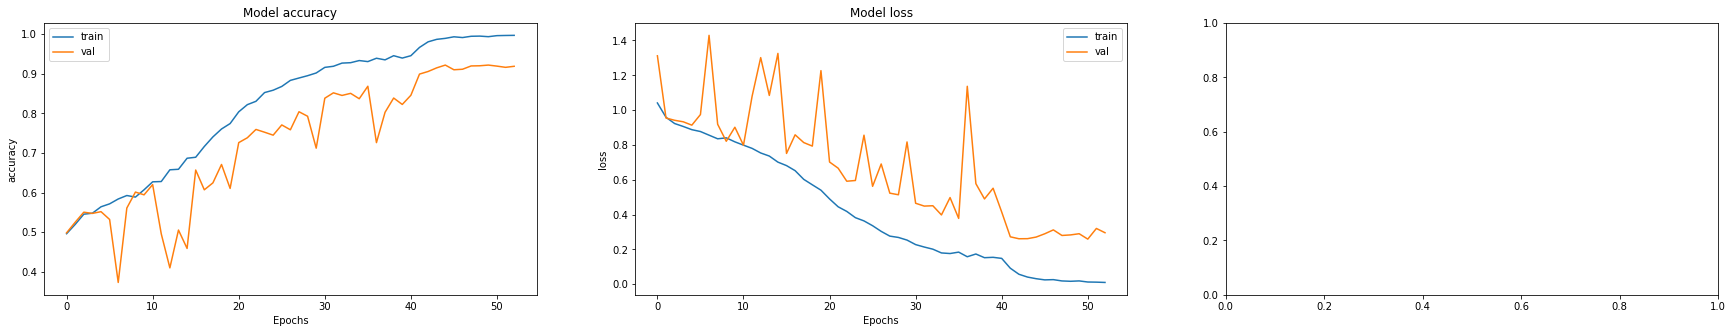

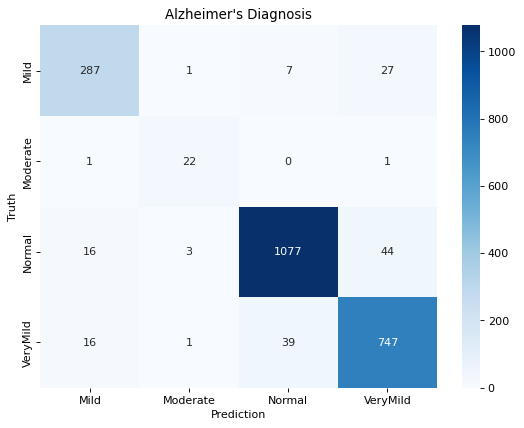

------Weighted------
Weighted precision 0.9323108562241784
Weighted recall 0.9318479685452162
Weighted f1-score 0.9319885847199931
------Macro------
Macro precision 0.8957040042991457
Macro recall 0.920742343975158
Macro f1-score 0.9074362559862734
------Micro------
Micro precision 0.9318479685452162
Micro recall 0.9318479685452162
Micro f1-score 0.9318479685452162


In [32]:
reset_keras()
get_result_2(model_history,Mob_model,test_data)